# pipeline2 model test

## (according to the code on the group github)

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import random
import statsmodels.api as sm
random.seed(3888)
np.random.seed(3888)

target_path = "order_book_target.parquet"
feature_path = "order_book_feature.parquet"

# Load parquet files (first 30 mins = feature, last 30 mins = target side of the hour)
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')

# Concatenating both DataFrames vertically (stacking feature + target rows)
# Note: This doesn't align features and targets — it's just combining both halves of the hour
combined_df = pd.concat([feature_df, target_df], axis=0)

# Sort to organize by stock, time, and within-hour time buckets
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)


combined_df = combined_df[combined_df['stock_id'] == 50200]

combined_df.head()





,stock_id,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
27224315,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510
27224316,50200,6,1800.0,372.48,372.50,372.47,372.51,200,200,1408,510
27224317,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300
27224318,50200,6,1801.0,372.47,372.48,372.46,372.49,435,830,608,300
27224319,50200,6,1802.0,372.46,372.47,372.45,372.48,100,100,508,1500


## Feature Engineering


In [11]:
def compute_orderbook_features(combined_df):
    spy_data = combined_df.copy()

    # === 基础特征计算 ===
    spy_data['mid_price'] = (spy_data['bid_price1'] + spy_data['ask_price1']) / 2
    spy_data['wap'] = (spy_data['bid_price1'] * spy_data['ask_size1'] + spy_data['ask_price1'] * spy_data['bid_size1']) / (
        spy_data['bid_size1'] + spy_data['ask_size1']
    )
    spy_data['bid_ask_spread'] = spy_data['ask_price1'] - spy_data['bid_price1']
    spy_data['spread_pct'] = spy_data['bid_ask_spread'] / spy_data['mid_price']
    spy_data['spread_variation'] = spy_data.groupby(['stock_id', 'time_id'])['spread_pct'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std()
    )
    spy_data['imbalance'] = (spy_data['bid_size1'] - spy_data['ask_size1']) / (spy_data['bid_size1'] + spy_data['ask_size1'])
    spy_data['depth_ratio'] = spy_data['bid_size1'] / spy_data['ask_size1'].replace(0, np.nan)

    spy_data['wap_lag1'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].shift(1)
    spy_data['wap_return'] = (spy_data['wap'] - spy_data['wap_lag1']) / spy_data['wap_lag1']
    spy_data['log_return'] = np.log(spy_data['wap'] / spy_data['wap_lag1'].replace(0, np.nan))

    spy_data['wap_mean_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean())
    spy_data['wap_std_10'] = spy_data.groupby(['stock_id', 'time_id'])['wap'].transform(
        lambda x: x.rolling(window=10, min_periods=1).std())

    # === Realized Volatility ===
    rv_df = spy_data.groupby(['stock_id', 'time_id'])['log_return'].agg(
        lambda x: np.sqrt(np.sum(x ** 2))
    ).reset_index().rename(columns={"log_return": "realized_volatility"})

    spy_data = pd.merge(spy_data, rv_df, on=["stock_id", "time_id"], how="left")

    # === HAR-RV ===
    spy_data = spy_data.sort_values(by=['stock_id', 'time_id'])
    spy_data['RV_lag1'] = spy_data.groupby('stock_id')['realized_volatility'].shift(1)
    spy_data['RV_lag5'] = spy_data.groupby('stock_id')['realized_volatility'].rolling(window=5).mean().reset_index(level=0, drop=True).shift(1)
    spy_data['RV_lag22'] = spy_data.groupby('stock_id')['realized_volatility'].rolling(window=22).mean().reset_index(level=0, drop=True).shift(1)

    keep_cols = [
        'stock_id', 'time_id', 'seconds_in_bucket',
        'wap', 'wap_lag1', 'wap_return', 'log_return',
        'wap_mean_10', 'wap_std_10',
        'spread_pct', 'spread_variation', 'bid_ask_spread',
        'imbalance', 'depth_ratio',
        'realized_volatility', 'RV_lag1', 'RV_lag5', 'RV_lag22'
    ]
    return spy_data[keep_cols]



In [12]:

time_ref_df = pd.read_csv("time_id_reference.csv")
time_ref_df.head()

feature_engineered_df = compute_orderbook_features(combined_df)

In [13]:
time_ref_df["datetime"] = pd.to_datetime(time_ref_df["date"] + " " + time_ref_df["time"])

feature_engineered_df = pd.merge(
    feature_engineered_df.drop(columns=["datetime"], errors="ignore"),  # just in case it already exists
    time_ref_df[["time_id", "datetime"]],
    on="time_id",
    how="left"
)
feature_engineered_df.tail()

,stock_id,time_id,seconds_in_bucket,wap,wap_lag1,wap_return,log_return,wap_mean_10,wap_std_10,spread_pct,spread_variation,bid_ask_spread,imbalance,depth_ratio,realized_volatility,RV_lag1,RV_lag5,RV_lag22,datetime
4166783,50200,1199,3595.0,438.471429,438.496250,-0.000057,-0.000057,438.496120,0.048162,0.000023,0.000011,0.01,-0.714286,0.166667,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00
4166784,50200,1199,3596.0,438.490714,438.471429,0.000044,0.000044,438.488555,0.041364,0.000023,0.000011,0.01,-0.857143,0.076923,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00
4166785,50200,1199,3597.0,438.491579,438.490714,0.000002,0.000002,438.480113,0.027986,0.000023,0.000010,0.01,-0.684211,0.187500,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00
4166786,50200,1199,3598.0,438.547500,438.491579,0.000128,0.000128,438.481828,0.031688,0.000023,0.000010,0.01,0.500000,3.000000,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00
4166787,50200,1199,3599.0,438.577500,438.547500,0.000068,0.000068,438.493225,0.042891,0.000023,0.000007,0.01,0.500000,3.000000,0.002432,0.002432,0.002432,0.002432,2021-10-07 16:00:00


# 50200hav-rv model pipeline1

## code from github file of research/104919_hav_rv_v1.ipynb

In [16]:
# Example with SPY XNAS
spy_df = feature_engineered_df.copy()
print(spy_df.tail())

# Check the datetime available
spy_df["date_only"] = spy_df["datetime"].dt.date

         stock_id  time_id  seconds_in_bucket         wap    wap_lag1  \
4166783     50200     1199             3595.0  438.471429  438.496250   
4166784     50200     1199             3596.0  438.490714  438.471429   
4166785     50200     1199             3597.0  438.491579  438.490714   
4166786     50200     1199             3598.0  438.547500  438.491579   
4166787     50200     1199             3599.0  438.577500  438.547500   

         wap_return  log_return  wap_mean_10  wap_std_10  spread_pct  \
4166783   -0.000057   -0.000057   438.496120    0.048162    0.000023   
4166784    0.000044    0.000044   438.488555    0.041364    0.000023   
4166785    0.000002    0.000002   438.480113    0.027986    0.000023   
4166786    0.000128    0.000128   438.481828    0.031688    0.000023   
4166787    0.000068    0.000068   438.493225    0.042891    0.000023   

         spread_variation  bid_ask_spread  imbalance  depth_ratio  \
4166783          0.000011            0.01  -0.714286     0.

In [17]:
#  Compute log returns (per time_id)
spy_df["log_return"] = spy_df.groupby("time_id")["wap"].transform(lambda x: np.log(x / x.shift(1)))


# Compute realized volatility per time_id
rv_df = spy_df.groupby("time_id")["log_return"].agg(lambda x: np.sqrt(np.sum(x**2))).reset_index()

rv_df = rv_df.rename(columns={"log_return": "realized_volatility"})

#  Merge back into spy_df
spy_df = pd.merge(spy_df, rv_df, on="time_id", how="left")

In [18]:
# Helper function 

def evaluate_model(true, pred):
    # Clip predicted values to avoid log(0) or division by 0
    pred_clipped = np.clip(pred, 1e-4, None)
    true = np.array(true)
    
    # MSE
    mse = mean_squared_error(true, pred_clipped)

    # QLIKE
    try:
        qlike_score = np.mean(np.log(pred_clipped**2) + (true**2) / (pred_clipped**2))
    except Exception as e:
        qlike_score = np.nan
        print("QLIKE calculation failed:", e)

    print(f"Test MSE: {mse:.8f}")
    print(f"Test QLIKE: {qlike_score:.8f}")

    return mse, qlike_score

Test MSE: 0.00000036
Test QLIKE: -11.70167721


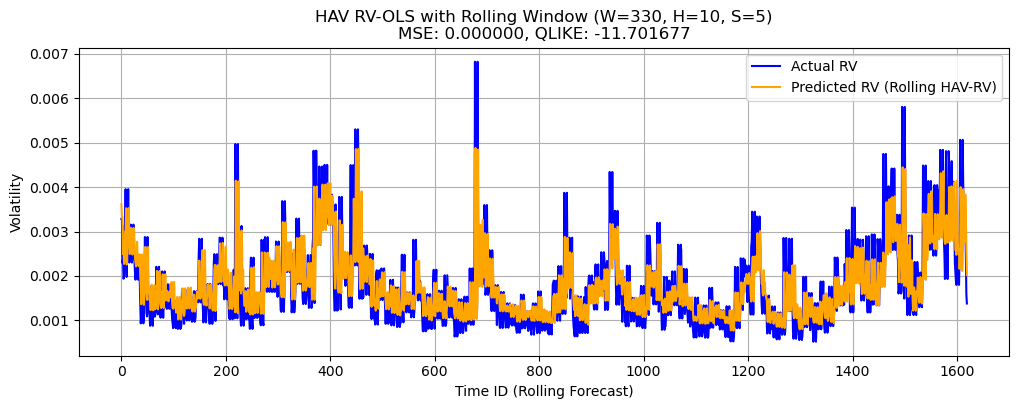

In [19]:
# HAV RV OLS
# Prepare lagged HAV features
hav_df = rv_df.copy()
hav_df["rv_lag_1"] = hav_df["realized_volatility"].shift(1)
hav_df["rv_lag_5"] = hav_df["realized_volatility"].shift(5)
hav_df["rv_lag_10"] = hav_df["realized_volatility"].shift(10)
hav_df = hav_df.dropna().reset_index(drop=True)

# Set rolling window parameters
W, H, S = 330, 10, 5  # Window size, forecast horizon, step size

# Rolling window forecasting
all_preds = []
all_actuals = []
all_time_ids = []

for start in range(0, len(hav_df) - W - H + 1, S):
    train_window = hav_df.iloc[start:start + W]
    test_window = hav_df.iloc[start + W:start + W + H]

    # Fit model on rolling window
    X_train = sm.add_constant(train_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
    y_train = train_window["realized_volatility"]
    model = sm.OLS(y_train, X_train).fit()

    # Predict
    X_test = sm.add_constant(test_window[["rv_lag_1", "rv_lag_5", "rv_lag_10"]])
    preds = model.predict(X_test)

    all_preds.extend(preds)
    all_actuals.extend(test_window["realized_volatility"].values)
    
    #reocrd test of time_id
    time_ids = test_window["time_id"].values
    all_time_ids.extend(time_ids)  #  all_time_ids.append(time_ids[0])



# Evaluate 
preds = np.array(all_preds)
actuals = np.array(all_actuals)
#call helper function
mse_ols, qlike_ols = evaluate_model(actuals, preds)

# Plot predicted and actual volatility
plt.figure(figsize=(12, 4))
plt.plot(actuals, label="Actual RV", color="blue")
plt.plot(preds, label="Predicted RV (Rolling HAV-RV)", color="orange")
plt.title(f"HAV RV-OLS with Rolling Window (W={W}, H={H}, S={S})\nMSE: {mse_ols:.6f}, QLIKE: {qlike_ols:.6f}")
plt.xlabel("Time ID (Rolling Forecast)")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
pred_df = pd.DataFrame({
    "time_id": all_time_ids,  
    "predicted_volatility": preds
})

feature_engineered_df["time_id"] = feature_engineered_df["time_id"].astype(int)
pred_df["time_id"] = pred_df["time_id"].astype(int)

feature_engineered_df_test = feature_engineered_df[
    feature_engineered_df["time_id"].isin(pred_df["time_id"])
]

pipeline2_input = feature_engineered_df_test.merge(pred_df, on="time_id", how="left")

In [21]:
print(len(pipeline2_input))
print(len(feature_engineered_df))

5829931
4166788


In [22]:
print(sorted(feature_engineered_df["time_id"].unique())[:10]) 
print(sorted(pred_df["time_id"].unique())[:10])              


[6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[358, 359, 360, 361, 362, 363, 364, 365, 366, 367]


## Hav-rv ols and wls


### test and train

In [25]:

unique_ids = sorted(pipeline2_input["time_id"].unique())
cutoff = int(len(unique_ids) * 0.8)
train_ids = unique_ids[:cutoff]
test_ids = unique_ids[cutoff:]

train_data = pipeline2_input[pipeline2_input["time_id"].isin(train_ids)]
test_data = pipeline2_input[pipeline2_input["time_id"].isin(test_ids)]

X_train = train_data[['predicted_volatility']]
y_train = train_data['bid_ask_spread']

X_test = test_data[['predicted_volatility']]
y_test = test_data['bid_ask_spread']



In [26]:
# OLS
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_ols = ols_model.predict(X_test)

# WLS 
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

weights = 1 / (X_train['predicted_volatility'] + 1e-6)


wls_model = sm.WLS(y_train, X_train_sm, weights=weights)
wls_results = wls_model.fit()
y_pred_wls = wls_results.predict(X_test_sm)

# QLIKE
def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None) 
    return np.mean(np.log(y_pred**2) + (y_true**2) / (y_pred**2))


print("OLS")
print("MSE:", round(mean_squared_error(y_test, y_pred_ols), 6))
print("QLIKE:", round(qlike(y_test.values, y_pred_ols), 6))

print("\n WLS")
print("MSE:", round(mean_squared_error(y_test, y_pred_wls), 6))
print("QLIKE:", round(qlike(y_test.values, y_pred_wls), 6))

OLS
MSE: 1.7e-05
QLIKE: -7.683619

 WLS
MSE: 1.7e-05
QLIKE: -7.68487


## XGboost


### test and train

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_cols = ['predicted_volatility'] 
y_col = 'bid_ask_spread'

df_clean = pipeline2_input.dropna(subset=X_cols + [y_col])
X = df_clean[X_cols]
y = df_clean[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#  XGBoost 
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

def qlike(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-8, None)  
    return np.mean(np.log(y_pred**2) + (y_true**2) / (y_pred**2))


mse = mean_squared_error(y_test, y_pred)
qlike_score = qlike(y_test.values, y_pred)

print(" MSE:", round(mse, 8))
print(" QLIKE:", round(qlike_score, 8))

importance_df = pd.DataFrame({
    'Feature': model.feature_names_in_,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=True)


 MSE: 1.322e-05
 QLIKE: -7.81811548


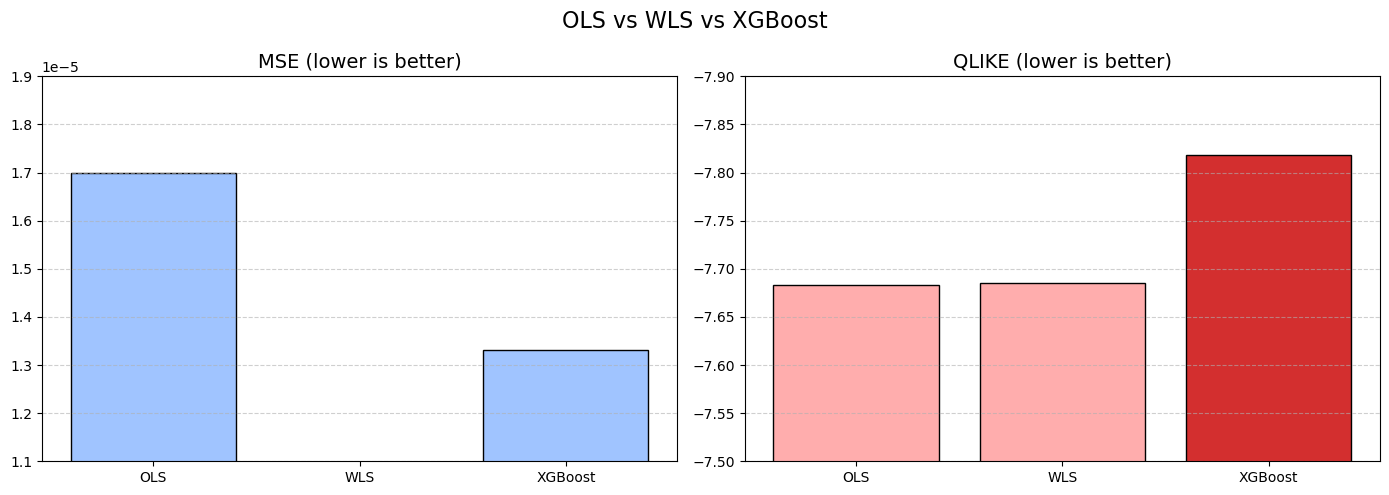

In [50]:

models = ['OLS', 'WLS', 'XGBoost']
mse_scores = [1.7e-05,1.7e-055, 1.332e-05]
qlike_scores = [-7.683619, -7.68487,-7.81811548]

#  find the best model
best_mse_idx = np.argmin(mse_scores)
best_qlike_idx = np.argmin(qlike_scores)

 # deep blue
mse_colors = ['#A0C4FF'] * 3
mse_colors[best_mse_idx] = '#1976D2' 

 # deep red
qlike_colors = ['#FFADAD'] * 3
qlike_colors[best_qlike_idx] = '#D32F2F' 

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# MSE plot
bars1 = axs[0].bar(models, mse_scores, color=mse_colors, edgecolor='black')
axs[0].set_title('MSE (lower is better)', fontsize=14)
axs[0].set_ylim(1.1e-5, 1.90e-5)
axs[0].grid(axis='y', linestyle='--', alpha=0.6)


# QLIKE plot
bars2 = axs[1].bar(models, qlike_scores, color=qlike_colors, edgecolor='black')
axs[1].set_title('QLIKE (lower is better)', fontsize=14)
axs[1].set_ylim(-7.50, -7.90)
axs[1].grid(axis='y', linestyle='--', alpha=0.6)


plt.suptitle('OLS vs WLS vs XGBoost' , fontsize=16)
plt.tight_layout()
plt.show()
